In [262]:
import cv2
import pickle
import pixy2
import numpy as np
import time
import math
import IPython
import matplotlib.pyplot as plt
from recordclass import recordclass
from matplotlib.pyplot import imshow as show
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

In [166]:
with open('dataset/pixy2_vector_dataset.obj', 'rb') as f:
    data = pickle.load(f)
    width, height = data[0]
    frames = data[1:]
    fps = 60

In [3]:
def imshow(img):
    _, ret = cv2.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [688]:
def get_angle_against_oy(v):
    x1, y1 = v[0:2]
    x2, y2 = v[2:4]
    dx = x2 - x1
    dy = y2 - y1
    
    radians = math.atan2(dy, dx)
    degrees = math.degrees(radians) + 90
    
    return degrees

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

def calc_direction_from_lanes(lanes):
    v = np.sum(lanes, axis=0) / len(lanes)
    angle = get_angle_against_oy(v.flatten())
    magnitude = int(distance(v[0,:], v[1,:]))
    
    return angle, magnitude

def window_based_interpolation(magnitude, height, width):
    longest_line = math.sqrt(height ** 2 + width ** 2)
    percent_magnitude = int(100 * magnitude / longest_line)
    
    return percent_magnitude

def detect_lanes_from_vector_frame(frame, height, width):
    # region of interest
    a = (0, height-1)
    b = (25, 30)
    c = (53, 30)
    d = (width-1, height-1)
    roi = [a, b, c, d]
    pts1 = np.float32(roi)
    win_size = height = width = 500
    pts2 = np.float32([[0, height-1], [0, 0], [width-1, 0], [width-1, height-1]])
    
    # get perspective and warp the image
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    
    # warped vectors
    warped_vectors = [] 
    
    for vector in frame:
        # check this to understand why the reshape has to be called
        # https://stackoverflow.com/a/46048098/2096747
        line = np.array([[vector.x0, vector.y0], [vector.x1, vector.y1]], dtype=np.float32)
        line = line.reshape(2, 1, -1)
        warped = cv2.perspectiveTransform(src=line, m=transform)
        warped = np.array(warped.reshape(2, 2), dtype=np.int32)
        warped_vectors.append(warped)
    
    # for vectors that are also placed outside the roi, just crop them
    filtered_vectors = []
    for vector in warped_vectors:
        x_col = vector[:, 0]
        y_col = vector[:, 1]
        if np.any((x_col >= 0) & (x_col < win_size)):
            if np.any((y_col >= 0) & (y_col < win_size)):
                y_col[y_col < 0] = 0
                y_col[y_col >= win_size] = win_size - 1
                x_col[x_col < 0] = 0
                x_col[x_col >= win_size] = win_size - 1
                filtered_vectors.append(vector)
    
    # remove vectors that only reside in the upper half horizontal plane of the roi
    thresholded_vectors = []
    for vector in filtered_vectors:
        y_col = vector[:, 1]
        if np.any(y_col >= (win_size // 2)):
            thresholded_vectors.append(vector)
            
    return thresholded_vectors, win_size, roi

def detect_lanes_from_vector_frames(frames, height, width, fill_gaps=False):
    angles = []
    magnitudes = []
    previous_angle = 0
    previous_magnitude = 0
    
    for frame in frames:
        lanes, win_size, roi = detect_lanes_from_vector_frame(frame, height, width)
        
        if len(lanes) > 0:
            angle, magnitude = calc_direction_from_lanes(lanes)
            magnitude = window_based_interpolation(magnitude, win_size, win_size)

            if angle is None:
                if fill_gaps is True:
                    angle = previous_angle
                else:
                    continue
            if angle < -90:
                angle = -90
            elif angle >= 90:
                angle = 90
            
            angles.append(angle)
            magnitudes.append(magnitude)
            
            previous_angle = angle
            previous_magnitude = magnitude
        elif fill_gaps is True:
            angles.append(previous_angle)
            magnitudes.append(previous_magnitude)
        
    return angles, magnitudes

In [689]:
lanes, winsize, roi = detect_lanes_from_vector_frame(frames[3978], height, width)
calc_direction_from_lanes(lanes)
lanes

[array([[154, 460],
        [331,  61]], dtype=int32)]

In [690]:
frames[0]

[Vector(x0=65, y0=51, x1=55, y1=38, index=220, flags=0),
 Vector(x0=12, y0=45, x1=24, y1=34, index=0, flags=0),
 Vector(x0=4, y0=51, x1=12, y1=45, index=1, flags=2)]

In [837]:
angles, magnitudes = detect_lanes_from_vector_frames(frames, height, width, fill_gaps=True)

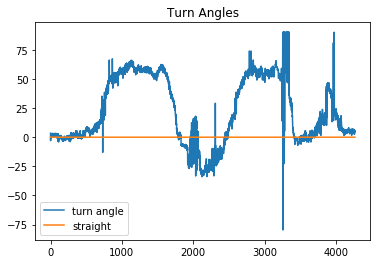

In [916]:
plt.plot(angles)
plt.plot([0] * len(angles))
plt.title('Turn Angles')
plt.legend(['turn angle', 'straight'], loc='lower left')
plt.show()

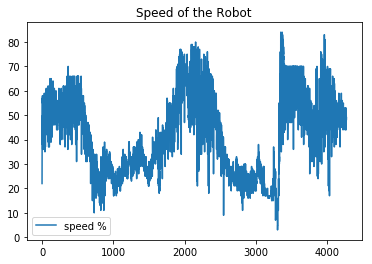

In [917]:
plt.plot(magnitudes)
plt.title('Speed of the Robot')
plt.legend(['speed %'], loc='lower left')

In [846]:
def exponential_moving_average(in_data_points, alfa):
    previous_y_sum = 0
    data_points = []
    
    for point in in_data_points:
        new_y_sum = alfa * point + (1 - alfa) * previous_y_sum
        data_points.append(new_y_sum)
        previous_y_sum = new_y_sum
        
    return data_points

In [927]:
alfa = 0.08
ema_angles = exponential_moving_average(angles, alfa)
ema_magnitudes = exponential_moving_average(magnitudes, alfa)

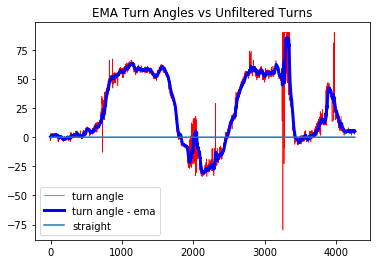

In [928]:
plt.plot(angles, lw=0.6, color='red')
plt.plot(ema_angles, lw=3, color='blue')
plt.plot([0] * len(ema_angles))
plt.title('EMA Turn Angles vs Unfiltered Turns')
plt.legend(['turn angle', 'turn angle - ema', 'straight'], loc='lower left')
plt.show()

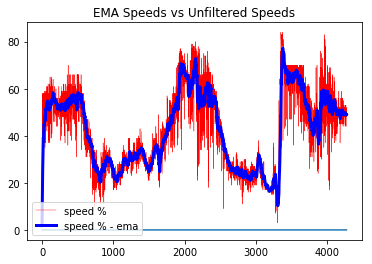

In [929]:
plt.plot(magnitudes, lw=0.4, color='red')
plt.plot(ema_magnitudes, lw=3, color='blue')
plt.plot([0] * len(ema_magnitudes))
plt.title('EMA Speeds vs Unfiltered Speeds')
plt.legend(['speed %', 'speed % - ema'], loc='lower left')
plt.show()

In [921]:
def create_video_from_vectors_with_overlay(output, frames, angles, magnitudes, height, width, scale, fps):
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    nh = scale * height
    nw = scale * width
    video = cv2.VideoWriter(output, 
                            fourcc, 
                            float(fps), 
                            (nw, nh), 0)
    font = cv2.FONT_HERSHEY_SIMPLEX

    for frame_index, frame in enumerate(frames):
        
        img = np.zeros([nh, nw], dtype=np.uint8)
        angle = int(angles[frame_index])
        magnitude = int(magnitudes[frame_index])
        
        for vect in frame:
            cv2.line(img, (vect.x0 * scale, vect.y0 * scale), (vect.x1 * scale, vect.y1 * scale), color=255, thickness=1)
            cv2.putText(img, 'Frame {}'.format(frame_index), (int(0.1 * nh), int(0.1 * nw)), font, 0.5, 255, 1, cv2.LINE_AA)
            cv2.putText(img, 'Angle {}'.format(angle), (int(0.85 * nh), int(0.1 * nw)), font, 0.5, 255, 1, cv2.LINE_AA)
            cv2.putText(img, 'Mag {}'.format(magnitude), (int(0.85 * nh), int(0.15 * nw)), font, 0.5, 255, 1, cv2.LINE_AA)
        video.write(img)
        
    video.release()

In [934]:
video_scale = 5
create_video_from_vectors_with_overlay(
    'videos/efficient_pixy2_lane_follower.avi', 
    frames, angles, magnitudes, height, width, video_scale, fps)

In [935]:
create_video_from_vectors_with_overlay(
    'videos/ema_efficient_pixy2_lane_follower.avi', 
    frames, ema_angles, ema_magnitudes, height, width, video_scale, fps)